In [702]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split

In [703]:
path_df = "/home/taiel/Documentos/FIUBA/2024_C1/OrgaDeDatos/7506R-1C2024-GRUPO01/TP1/properati_argentina_2021.csv"

In [704]:
GREEN = "#196F3D"
BLUE = "#2874A6"

In [705]:
df_raw = pd.read_csv(path_df)

In [706]:
df_raw.shape

(460154, 20)

In [707]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460154 entries, 0 to 460153
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        460154 non-null  object 
 1   start_date                460154 non-null  object 
 2   end_date                  460154 non-null  object 
 3   created_on                460154 non-null  object 
 4   latitud                   419740 non-null  float64
 5   longitud                  419740 non-null  float64
 6   place_l2                  460154 non-null  object 
 7   place_l3                  437665 non-null  object 
 8   place_l4                  139020 non-null  object 
 9   place_l5                  2430 non-null    object 
 10  place_l6                  0 non-null       float64
 11  operation                 460154 non-null  object 
 12  property_type             460154 non-null  object 
 13  property_rooms            368498 non-null  f

In [708]:
df_raw.head(3)

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay


In [709]:
# Esta info no la mostraría, total los datos que importan son despues de filtrar y despues de dividir en prueba y entrenamiento
df_raw.isnull().sum()

id                               0
start_date                       0
end_date                         0
created_on                       0
latitud                      40414
longitud                     40414
place_l2                         0
place_l3                     22489
place_l4                    321134
place_l5                    457724
place_l6                    460154
operation                        0
property_type                    0
property_rooms               91656
property_bedrooms           116041
property_surface_total       62341
property_surface_covered     32238
property_price               18001
property_currency            18564
property_title                   0
dtype: int64

## Análisis exploratorio

Arrancamos filtrando el df segun lo que indica la consigna.

In [710]:
df_raw["property_currency"].value_counts()

property_currency
USD    349104
ARS     88869
UYU      3506
PEN        99
COP        12
Name: count, dtype: int64

In [711]:
df_raw["operation"].value_counts()

operation
Venta                337874
Alquiler              98900
Alquiler temporal     23380
Name: count, dtype: int64

In [712]:
df_raw["property_type"].value_counts()

property_type
Departamento       231358
Casa               120768
Lote                28748
PH                  25910
Local comercial     20546
Oficina             16085
Otro                 7713
Cochera              4111
Depósito             4050
Casa de campo         865
Name: count, dtype: int64

In [713]:
tipos_propiedades = ["Departamento", "Casa", "PH"]

In [714]:
df_raw["place_l2"].value_counts()

place_l2
Capital Federal                 157563
Bs.As. G.B.A. Zona Norte         89693
Santa Fe                         47861
Bs.As. G.B.A. Zona Sur           47754
Bs.As. G.B.A. Zona Oeste         28352
Córdoba                          22528
Buenos Aires Costa Atlántica     12457
Neuquén                           8788
Montevideo                        7494
Buenos Aires Interior             6274
Maldonado                         5540
Mendoza                           5395
Río Negro                         5280
Tucumán                           3571
Colonia                           2535
Salta                             1537
Entre Ríos                        1216
San Juan                           997
La Pampa                           783
Canelones                          744
Chubut                             701
San Luis                           677
Misiones                           529
Florida                            411
Jujuy                              406
Corrientes      

In [715]:
# que pasa aca con aquellas que tengan nan de place_l2 pero que realmente esten en capital federal
# TODO: deberia buscar puntos extremos de CABA y ahi filtrar por eso tambien

In [716]:
## Filtramos el df con lo solicitado
df_raw = df_raw[(df_raw["property_currency"] == "USD") & (df_raw["operation"] == "Venta") & (df_raw["property_type"].isin(tipos_propiedades)) &
        (df_raw["place_l2"] == "Capital Federal")]

## Dividimos en un df para entrenamiento (llamado df) y otro para test (df_test)
seed = 123

_df, df_test = train_test_split(df_raw, test_size=0.2, random_state=seed)

df = _df # creo esta copia para luego poder comparar las distros antes y despues de imputar datos.

print(df_raw.shape)
print(_df.shape)
print(df_test.shape)

(94249, 20)
(75399, 20)
(18850, 20)


Text(0, 0.5, 'Porcentaje de valores nulos')

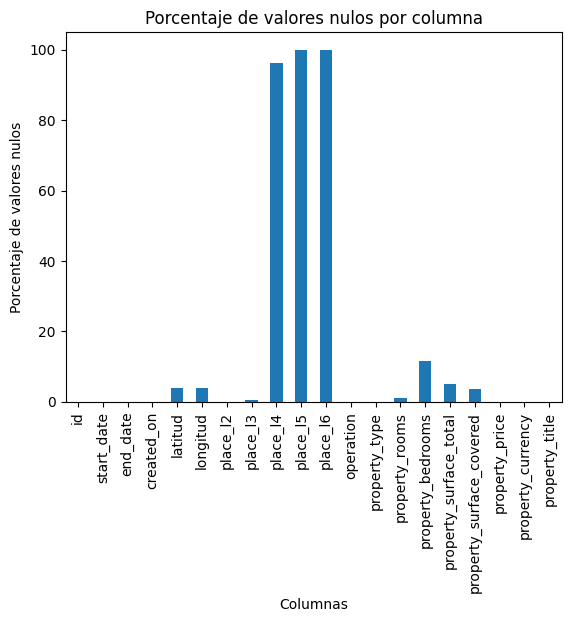

In [717]:
_df.isnull().sum()
# En lugar de mostrarlo de esta forma, usaría un gráfico mostrando los %.

porcentaje_null_por_columna = (_df.isnull().sum() / len(_df) * 100)
porcentaje_null_por_columna.plot(kind='bar')
plt.title('Porcentaje de valores nulos por columna')
plt.xlabel('Columnas')
plt.ylabel('Porcentaje de valores nulos')

### a) Exploración incial

Variables cuantitativas

In [718]:
df["start_date"].min()

'2021-01-01'

In [719]:
df["start_date"].max()

'2021-12-31'

In [720]:
df["end_date"].min()

'2021-01-02'

In [721]:
df["end_date"].max()

'9999-12-31'

In [722]:
df["created_on"].min()

'2021-01-01'

In [723]:
df["created_on"].max()

'2021-12-31'

Veo que de **end_date** a ciertas propiedades le colocaron el año 9999, por lo que interpreto que todavia no habian sido vendidas al momento de recolectar los datos.

Estas tres columnas veo que son variables cuantitativas discretas, ya que solo estan las fechas como tal, no hay dato sobre las horas.

Tanto **latitud** como **longitud** son variables cuantitativas continuas.

In [724]:
df["latitud"].mean(), df["latitud"].median(), df["latitud"].mode()[0]

(-34.59126352648724, -34.59573237315, -34.5412501)

In [725]:
df["longitud"].mean(), df["longitud"].median(), df["longitud"].mode()[0]

(-58.449369334704855, -58.4389166, -58.4729664)

Los distintos **place_l** son variables cualitativas. Busco los distintos valores que adoptan

In [726]:
df["place_l2"].value_counts()

place_l2
Capital Federal    75399
Name: count, dtype: int64

In [727]:
df["place_l3"].value_counts()

place_l3
Palermo                 11448
Belgrano                 7173
Caballito                5688
Recoleta                 5031
Villa Urquiza            3794
Almagro                  3291
Nuñez                    2839
Villa Crespo             2563
Flores                   2460
Barrio Norte             2418
Balvanera                2071
Colegiales               1571
Villa Devoto             1533
Saavedra                 1447
Villa del Parque         1446
Puerto Madero            1207
San Telmo                1118
San Nicolás              1053
San Cristobal            1027
Barracas                 1011
Retiro                    984
Boedo                     972
Floresta                  950
Monserrat                 893
Parque Chacabuco          859
Villa Pueyrredón          792
Coghlan                   771
Villa Luro                574
Mataderos                 572
Chacarita                 550
Liniers                   536
Villa Ortuzar             512
Parque Patricios          494
V

In [728]:
df["place_l4"].value_counts()

place_l4
Palermo Hollywood    1245
Palermo Chico         874
Palermo Soho          648
Palermo Viejo         136
Name: count, dtype: int64

In [729]:
df["place_l5"].value_counts()

Series([], Name: count, dtype: int64)

De la columna **place_l6** ni siquiera miramos porque el resultado de value_counts() con todo el df sin filtrarson todos nulos.

In [730]:
df["operation"].value_counts()

operation
Venta    75399
Name: count, dtype: int64

**Operation** originalmente es una variable de tipo cualitativa, y vemos que sus valores difieren de lo que son exclusivamente ventas de propiedades, asique nos preguntamos aqui si dichas filas con propiedades a alquilar nos van a servir para predecir el valor de una propiedad en venta.
En nuestro caso ya filtrado solo van a estar aquellas propiedades que tienen el valor de "Venta".

In [731]:
df["property_type"].value_counts()

property_type
Departamento    64698
PH               7392
Casa             3309
Name: count, dtype: int64

**property_type** originalmente es una variable de tipo cualitativa también, y vemos que los posibles valores difieren de edifcios, hoteles o establecimientos masivos (exceptuando las oficinas quizas), aunque propiedades de este tipo pueden estar agrupadas en Otro, asique es algo que tendremos en cuenta de aqui en adelante.
Idem lo dicho anteriormente, la variable con el filtrado previo solo va a variar entre las opciones anteriores.

In [732]:
df["property_rooms"].value_counts()

property_rooms
3.0     21380
2.0     21255
4.0     13152
1.0     12011
5.0      4100
6.0      1494
7.0       577
8.0       279
9.0       116
10.0       90
11.0       28
12.0       27
14.0       11
15.0        8
13.0        5
17.0        4
16.0        4
20.0        3
18.0        3
36.0        2
30.0        2
32.0        1
24.0        1
19.0        1
35.0        1
Name: count, dtype: int64

In [733]:
def check_values(column):
    result = []
    for n in column:
        if not np.isnan(n) and n % 1 != 0:
            result.append(n)
    return result

In [734]:
check_values(df["property_rooms"])

[]

In [735]:
df["property_rooms"].mean(), df["property_rooms"].median(), df["property_rooms"].mode()[0]

(2.8221715512038092, 3.0, 3.0)

In [736]:
df["property_bedrooms"].value_counts()

property_bedrooms
 1.0     25641
 2.0     21928
 3.0     14103
 4.0      3841
 5.0       747
 6.0       184
 7.0        83
 8.0        45
 10.0       21
 9.0        21
 12.0       14
 11.0        6
 14.0        5
 17.0        5
 16.0        4
 13.0        4
 18.0        3
 15.0        3
 20.0        3
 32.0        3
 22.0        2
 70.0        1
-1.0         1
Name: count, dtype: int64

In [737]:
check_values(df["property_bedrooms"])

[]

In [738]:
df["property_bedrooms"].mean(), df["property_bedrooms"].median(), df["property_bedrooms"].mode()[0]

(2.013289734205316, 2.0, 1.0)

Tanto **property_rooms** como **property_bedrooms** vemos que son variables cuantitativas discretas, pero ya observamos que tiene algunos valores extraños (el -3, y aquellos que son muy altos, que pueden llegar a ser hoteles o similar, pero nuevamente, lo analizaremos mas adelante).

In [739]:
df["property_surface_covered"].value_counts()

property_surface_covered
40.0     1955
38.0     1633
50.0     1612
45.0     1557
35.0     1483
         ... 
537.0       1
608.0       1
492.0       1
302.0       1
317.0       1
Name: count, Length: 562, dtype: int64

In [740]:
check_values(df["property_surface_covered"])

[]

In [741]:
df["property_surface_covered"].mean(), df["property_surface_covered"].median(), df["property_surface_covered"].mode()[0]

(89.04041959387932, 58.0, 40.0)

In [742]:
df["property_surface_total"].value_counts()

property_surface_total
50.0      1445
40.0      1405
42.0      1273
45.0      1263
60.0      1209
          ... 
471.0        1
401.0        1
539.0        1
4632.0       1
723.0        1
Name: count, Length: 682, dtype: int64

In [743]:
check_values(df["property_surface_total"])

[]

In [744]:
df["property_surface_total"].mean(), df["property_surface_total"].median(), df["property_surface_total"].mode()[0]

(109.0961073450276, 65.0, 50.0)

Ambas variables indicadoras de la superficie de las propiedades (totales y cubiertas) son variables cuantitativas continuas, y vemos que hay discrepancia en los datos ya que superficie total = superficie cubierta + superficie descubierta, y el promedio de las superficie cubierta es 9000 aproximadamente, y el de la superficie total es 420 aproximadamente.

In [745]:
# o discretas?

In [746]:
df["property_price"].value_counts()

property_price
110000.0    1189
85000.0     1149
120000.0    1141
125000.0    1136
115000.0    1092
            ... 
70899.0        1
45999.0        1
207500.0       1
79847.0        1
529133.0       1
Name: count, Length: 4215, dtype: int64

In [747]:
check_values(df["property_price"])

[]

In [748]:
df["property_price"].mean(), df["property_price"].median(), df["property_price"].mode()[0]

(226092.01221501612, 144000.0, 110000.0)

El **property_price** es una variable cuantitativa discreta.

In [749]:
df["property_currency"].value_counts()

property_currency
USD    75399
Name: count, dtype: int64

**property_currency** originalmente es una variable cuantitativa tambien, y es la moneda en la que esta publicada la propiedad, asique ya sabemos que vamos a tener que traducir ciertas monedas a USD (o mismo ver si realmente pertenecen a la Argentina las propiedades del df).
Tras el filtrado solo tenemos aquellas propiedades publicadas con valor en USD.

In [750]:
df["property_title"].value_counts()

property_title
Departamento - Palermo                                                                          1182
Departamento - Recoleta                                                                         1064
Departamento - Belgrano                                                                          893
Departamento - Caballito                                                                         753
Departamento - Almagro                                                                           541
                                                                                                ... 
Excelente departamento 4 amb. C/ Dep y cochera!!!!                                                 1
4 AMBIENTES COCINA INDEPENDIENTE CON BALCÓN AL FRENTE                                              1
VENTA depto 5 amb en esquina luminosa c/ terraza y quincho priv - Serrano 700,  Palermo Soho       1
Venta departamento 3 ambientes con baulera                                  

El **property_title** es una variable cuantitativa.

### Resumen de esta sección

Creemos que las variables que refieren a los ids, a las fechas, y al titulo de la propiedad, no van a servir para entrenar al modelo, aquellas filas que refieran a propiedades en alquiler tampoco creemos que vayan a servirle al modelo, y por lo tanto ....

Realizando algunos graficos de lo que vemos mas importante ahora. Primero comparemos las distribuciones de los datos antes y despues de imputar datos.

In [751]:
def mostrar_distros(columna):
    fig = plt.figure(figsize = (8, 4))
    plt.subplot(1, 2, 1)
    plt.hist(_df[columna], bins=30, color=BLUE, alpha=0.7)
    plt.xlabel("Valores")
    plt.ylabel("Frecuencia")
    plt.title("Original")

    plt.subplot(1, 2, 2)
    plt.hist(df[columna], bins=30, color=GREEN, alpha=0.7)
    plt.xlabel("Valores")
    plt.ylabel("Frecuencia")
    plt.title("Tras imputar")

    fig.suptitle(f"Distribución de {columna}")
    plt.tight_layout()
    plt.show()

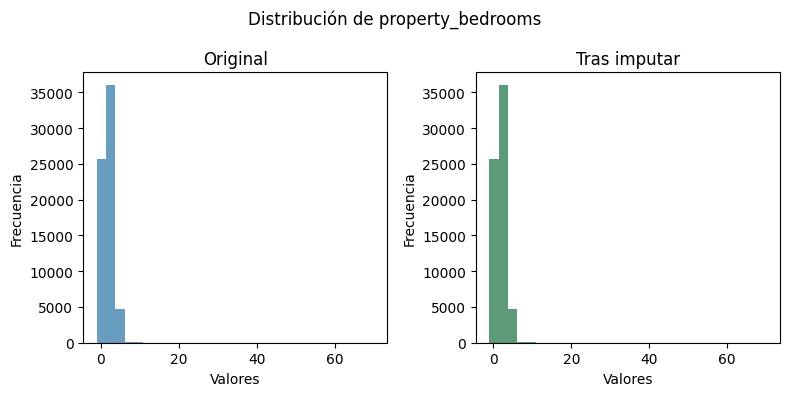

In [752]:
mostrar_distros("property_bedrooms")

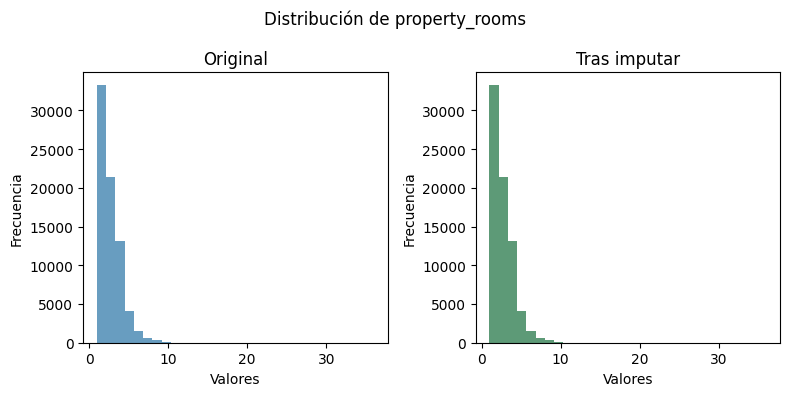

In [753]:
mostrar_distros("property_rooms")

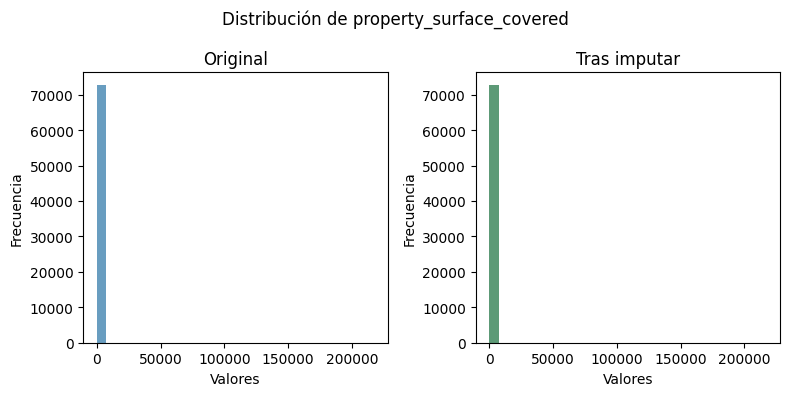

In [754]:
mostrar_distros("property_surface_covered")

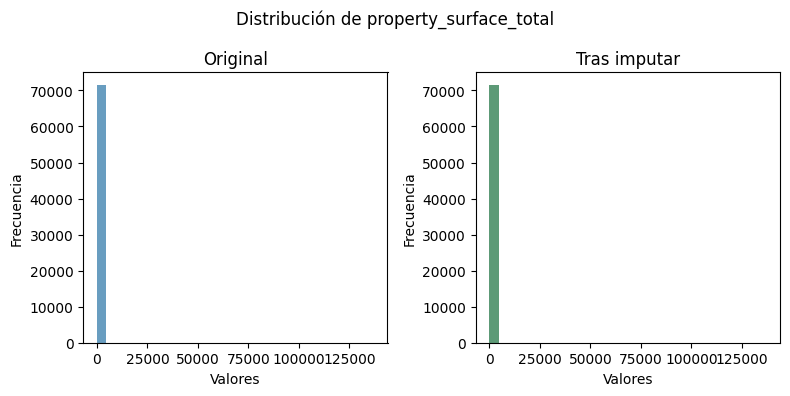

In [755]:
mostrar_distros("property_surface_total")

## Visualizaciones

In [756]:
#df = df.drop("id", axis = 1)

Busco si hay relación entre los valores de las propiedades y la ubicación en la que se encuentran.

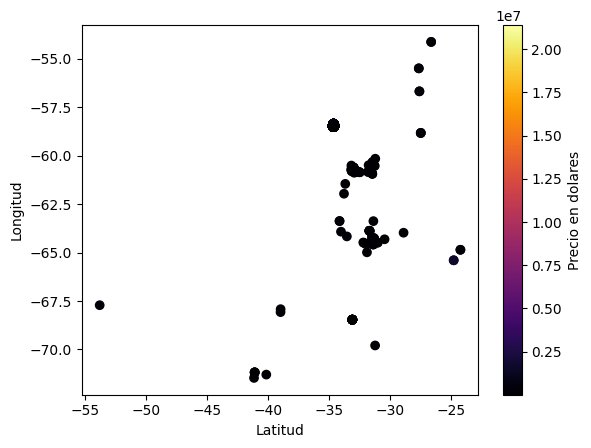

In [757]:
plt.scatter(df["latitud"], df["longitud"], c = df["property_price"], cmap="inferno")
plt.xlabel("Latitud")
plt.ylabel("Longitud")
plt.colorbar(label="Precio en dolares")

#cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{np.exp(x):.0f}"))
plt.show()

Busco la relación entre el precio de la propiedad y sus habitaciones/dimensiones.

<Axes: >

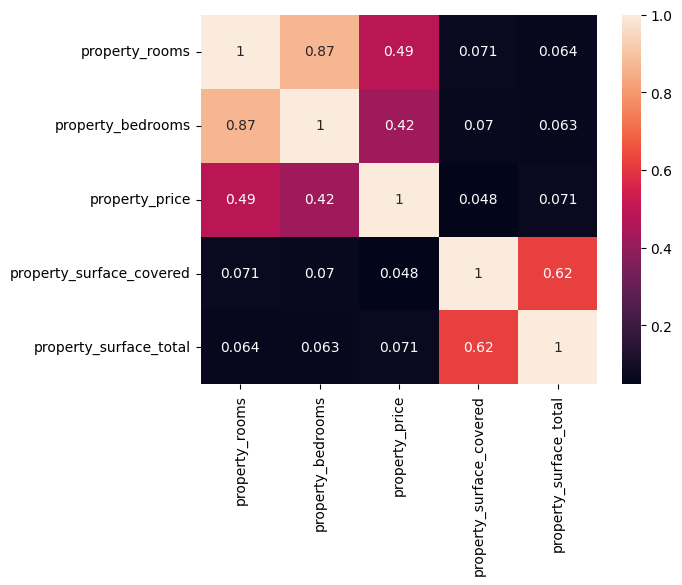

In [758]:
sns.heatmap(df[["property_rooms", "property_bedrooms", "property_price", "property_surface_covered", "property_surface_total"]].corr(), annot = True)

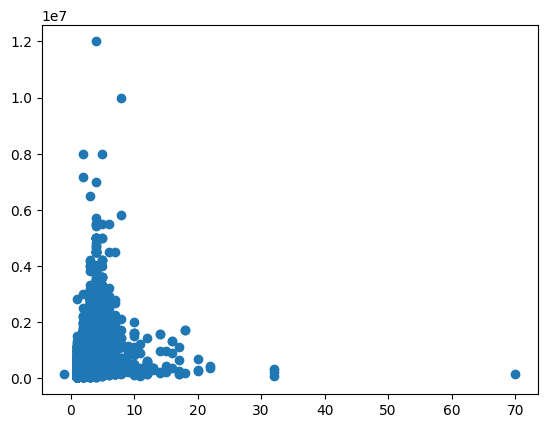

In [759]:
plt.scatter(df["property_bedrooms"], df["property_price"])

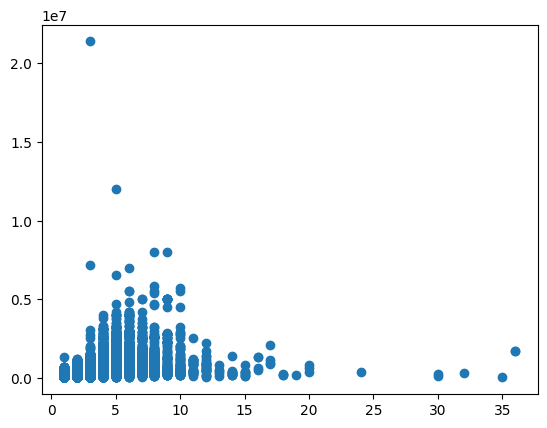

In [760]:
plt.scatter(df["property_rooms"], df["property_price"])

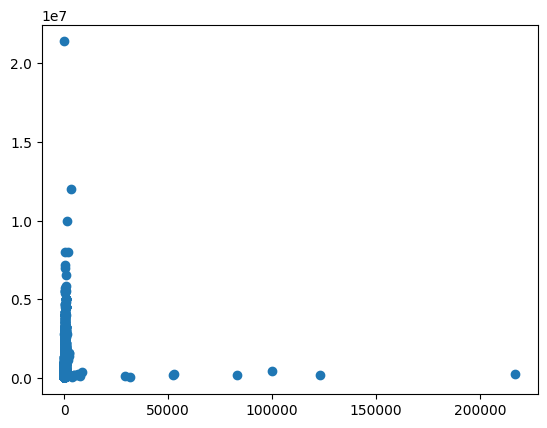

In [761]:
plt.scatter(df["property_surface_covered"], df["property_price"])

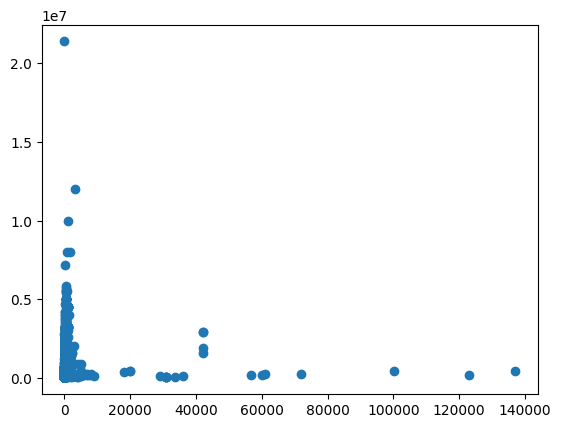

In [762]:
plt.scatter(df["property_surface_total"], df["property_price"])

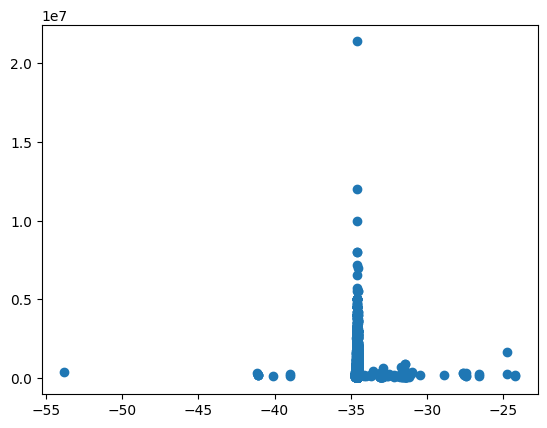

In [763]:
plt.scatter(df["latitud"], df["property_price"])

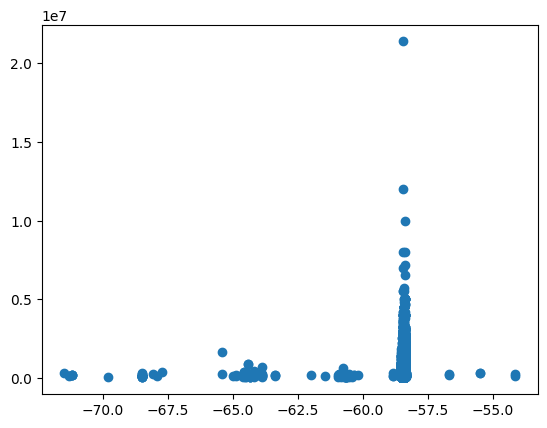

In [764]:
plt.scatter(df["longitud"], df["property_price"])

## Datos faltantes

In [765]:
df.shape

(75399, 20)

In [766]:
df.isnull().sum()

id                              0
start_date                      0
end_date                        0
created_on                      0
latitud                      3013
longitud                     3013
place_l2                        0
place_l3                      322
place_l4                    72496
place_l5                    75399
place_l6                    75399
operation                       0
property_type                   0
property_rooms                844
property_bedrooms            8731
property_surface_total       3854
property_surface_covered     2662
property_price                  0
property_currency               0
property_title                  0
dtype: int64

In [767]:
df[df["property_price"] <= 0].shape

(0, 20)

No veo propiedades con precios sin sentido.

In [768]:
df[df["property_surface_total"] < df["property_surface_covered"]].shape

(161, 20)

Hay 198 propiedades con errores en la superficie

Decidimos tomar como que el error estuvo en ingresar los datos al revés.

In [769]:
filas_erroneas = df["property_surface_total"] < df["property_surface_covered"]

df.loc[filas_erroneas, ["property_surface_total", "property_surface_covered"]] = df.loc[filas_erroneas, ["property_surface_covered", "property_surface_total"]].values

In [770]:
df.isnull().sum()

id                              0
start_date                      0
end_date                        0
created_on                      0
latitud                      3013
longitud                     3013
place_l2                        0
place_l3                      322
place_l4                    72496
place_l5                    75399
place_l6                    75399
operation                       0
property_type                   0
property_rooms                844
property_bedrooms            8731
property_surface_total       3854
property_surface_covered     2662
property_price                  0
property_currency               0
property_title                  0
dtype: int64

In [771]:
df.isnull().sum() / df.shape[0]

id                          0.000000
start_date                  0.000000
end_date                    0.000000
created_on                  0.000000
latitud                     0.039961
longitud                    0.039961
place_l2                    0.000000
place_l3                    0.004271
place_l4                    0.961498
place_l5                    1.000000
place_l6                    1.000000
operation                   0.000000
property_type               0.000000
property_rooms              0.011194
property_bedrooms           0.115797
property_surface_total      0.051115
property_surface_covered    0.035306
property_price              0.000000
property_currency           0.000000
property_title              0.000000
dtype: float64

Como las columnas place_l4, place_l5 y place_l6 tiene un 96,13%, 100% y 100% de nulos, respectivamente, las elimino.

In [772]:
df = df.drop("place_l4", axis=1)
df = df.drop("place_l5", axis=1)
df = df.drop("place_l6", axis=1)

In [773]:
df[df["property_rooms"].isnull() & df["property_bedrooms"].isnull()].shape[0]

351

Como las filas que no tienen ninguno de los datos de habitaciones/ambientes son solo 432 para un df de 94342, elimino dichas filas.

In [774]:
df = df[~(df["property_rooms"].isnull() & df["property_bedrooms"].isnull())]

Busco si hay propiedades que tengan valores nulos para la cantidad de ambientes y no nulos para la cantidad de habitaciones.

In [775]:
df[df["property_rooms"].isnull() & ~df["property_bedrooms"].isnull()].shape[0]

493

Completo aquellas filas que no tengan la cantidad de cuartos totales, pero si la cantidad de habitaciones, con cantHabitaciones + 1, ya que necesariamente tienen un ambiente más.

In [776]:
df["property_rooms"].fillna(df["property_bedrooms"] + 1, inplace=True)

Completamos ahora con la logica inversa aquellas viviendas que tengan el valor nulo en habitaciones pero no nulo en ambientes.

In [777]:
df[~(df["property_rooms"].isnull()) & (df["property_bedrooms"].isnull())].shape[0]

8380

In [778]:
df["property_bedrooms"].fillna(df["property_rooms"] - 1, inplace=True)

In [779]:
df.isnull().sum()

id                             0
start_date                     0
end_date                       0
created_on                     0
latitud                     2960
longitud                    2960
place_l2                       0
place_l3                     322
operation                      0
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total      3774
property_surface_covered    2621
property_price                 0
property_currency              0
property_title                 0
dtype: int64

Busco ahora la forma que tienen los datos nulos respecto a las superficies (total y descubierta)

In [780]:
df[df["property_surface_total"].isnull() & df["property_surface_covered"].isnull()].shape[0]

0

Completo aquellas filas que no tengan la cantidad superficie total, pero si la superficie cubierta, con la misma cantidad de superficie cubierta.

In [781]:
df[df["property_surface_total"].isnull() & ~df["property_surface_covered"].isnull()].shape[0]

3774

In [782]:
df["property_surface_total"].fillna(df["property_surface_covered"], inplace=True)

In [783]:
df.isnull().sum()

id                             0
start_date                     0
end_date                       0
created_on                     0
latitud                     2960
longitud                    2960
place_l2                       0
place_l3                     322
operation                      0
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total         0
property_surface_covered    2621
property_price                 0
property_currency              0
property_title                 0
dtype: int64

In [784]:
# Aca faltaria parchear los datos faltantes de property_surface_covered pero mmm, tiene que ser algo deterministico si no me equivoco,
# asique no podria tirar un random para bajarle un poco la cantidad respeccto al property_surface_total.

In [785]:
df[(df["latitud"].isnull()) & (df["longitud"].isnull()) & (df["place_l3"].isnull())].shape[0]

124

In [786]:
# Respecto a latitud_longitud, podria ver de poner el centro de capital (no me cierra mucho q digamos tampoco)
# solo 169 no tienen l3: podria descartar estos, y el resto buscar centro de cada barrio?
# y tambien me quedarian 416-169 datos de place_l3 que tiene latitud y longitud para ubicarlos :|

In [787]:
df[~df["latitud"].isnull() & ~df["longitud"].isnull() & df["place_l2"].isnull()].shape[0]

0

In [788]:
df[df["latitud"].isnull() & df["longitud"].isnull() & ~df["place_l2"].isnull()].shape[0]

2960

podriamos hacer aca lo de buscar el centro de los place_l2

In [789]:
df[df["latitud"].isnull() & df["longitud"].isnull()].shape[0]

2960

In [790]:
barrios = df["place_l3"].value_counts().index.tolist()
barrios = [b.upper() for b in barrios]

In [791]:
barrios

['PALERMO',
 'BELGRANO',
 'CABALLITO',
 'RECOLETA',
 'VILLA URQUIZA',
 'ALMAGRO',
 'NUÑEZ',
 'VILLA CRESPO',
 'FLORES',
 'BARRIO NORTE',
 'BALVANERA',
 'COLEGIALES',
 'VILLA DEVOTO',
 'VILLA DEL PARQUE',
 'SAAVEDRA',
 'PUERTO MADERO',
 'SAN TELMO',
 'SAN NICOLÁS',
 'SAN CRISTOBAL',
 'BARRACAS',
 'RETIRO',
 'BOEDO',
 'FLORESTA',
 'MONSERRAT',
 'PARQUE CHACABUCO',
 'VILLA PUEYRREDÓN',
 'COGHLAN',
 'VILLA LURO',
 'MATADEROS',
 'CHACARITA',
 'LINIERS',
 'VILLA ORTUZAR',
 'VILLA LUGANO',
 'PARQUE PATRICIOS',
 'PATERNAL',
 'CONGRESO',
 'MONTE CASTRO',
 'VILLA GENERAL MITRE',
 'CONSTITUCIÓN',
 'VILLA SANTA RITA',
 'ONCE',
 'PARQUE CHAS',
 'PARQUE AVELLANEDA',
 'BOCA',
 'VERSALLES',
 'VELEZ SARSFIELD',
 'AGRONOMÍA',
 'ABASTO',
 'POMPEYA',
 'VILLA REAL',
 'TRIBUNALES',
 'PARQUE CENTENARIO',
 'CENTRO / MICROCENTRO',
 'VILLA SOLDATI',
 'VILLA RIACHUELO',
 'LAS CAÑITAS',
 'CATALINAS']

In [792]:
df["property_title"].isnull().sum()

0

In [793]:
df[df["place_l3"].isnull()]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
248011,dYekUDR/71AGhrqQBjeSHw==,2021-09-13,2022-01-27,2021-09-13,-32.888004,-60.710540,Capital Federal,NaN,Venta,Departamento,4.0,2.0,67.0,67.0,40000.0,USD,Departamento en venta en Rucci de 2 dormitorio...
393092,9EiXFu6SwZ3s0e837avtGQ==,2021-02-13,2021-03-01,2021-02-13,NaN,NaN,Capital Federal,NaN,Venta,PH,2.0,1.0,39.0,44.0,118000.0,USD,Venta 2 Ambientes 44m Balcón al frente Boedo ...
371921,34/PRStI7EmJbD6zSjBAYw==,2021-08-24,2021-08-27,2021-08-24,NaN,NaN,Capital Federal,NaN,Venta,Casa,4.0,3.0,151.0,183.0,185000.0,USD,VENTA CASA COSTA ESMERALDA ECUESTRE 470
218048,vRA/0y8xkAUweY9h1T7EzA==,2021-11-30,9999-12-31,2021-11-30,NaN,NaN,Capital Federal,NaN,Venta,Casa,3.0,2.0,100.0,100.0,318000.0,USD,1 - Ruta 1 km 22 - Marina Santa Lucía
318763,21X2XW7KwPHKb73K0LDWUg==,2021-03-17,2021-06-05,2021-03-17,-27.469213,-58.830635,Capital Federal,NaN,Venta,Departamento,2.0,1.0,55.0,55.0,125000.0,USD,2 Ambientes de 70 mts2 reciclado a Nuevo. Con ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208085,2Xn6RKpg2Fps+wLCsSJavw==,2021-02-01,9999-12-31,2021-02-01,-41.085373,-71.185766,Capital Federal,NaN,Venta,Departamento,2.0,1.0,50.0,60.0,142000.0,USD,Excelente departamento en venta en Dina Huapi ...
106696,iV7+4ns6JXgPJSEj0D9ezg==,2021-03-11,2021-03-25,2021-03-11,NaN,NaN,Capital Federal,NaN,Venta,Departamento,3.0,2.0,87.0,87.0,129000.0,USD,"3 Ambientes amplios, 2 baños, prox galerias pa..."
286971,Ofh+oK3y43KJLYsPg0uj4w==,2021-06-16,2021-11-04,2021-06-16,NaN,NaN,Capital Federal,NaN,Venta,Departamento,2.0,1.0,43.0,43.0,110000.0,USD,Departamento en Venta Caba / Buenos Aires (B11...
169691,/HjGljAcks2boe1uclUdBg==,2021-07-28,2021-11-04,2021-07-28,NaN,NaN,Capital Federal,NaN,Venta,Departamento,3.0,2.0,45.0,45.0,75000.0,USD,Departamento en Venta Caba / Buenos Aires (B13...


In [794]:
df[(df["latitud"].isnull()) & (df["longitud"].isnull()) & (df["place_l3"].notnull())].shape

(2836, 17)

Aca veo que de las 3666 filas que tienen nulos en latitud y long, 3502 tienen place_l3 no nulos, podriamos buscar el centro de cada place_l3 y colocar eso de latitud y long.

Podria buscar en property_title los barrios publicados y ubicarlos en los place_l3 faltantes, pero tranquilamente podrian haber, por intereses del vendedor/la inmboliaria viviendas que correspondan a un barrio pero estan publicados en otro, por ahora ignoraremos eso.

In [795]:
df["property_title"] = df["property_title"].str.upper()

In [796]:
for b in barrios:
    df.loc[(df["place_l3"].isnull()) & (df["property_title"].str.contains(b)), "place_l3"] = b

In [797]:
df.isnull().sum()

id                             0
start_date                     0
end_date                       0
created_on                     0
latitud                     2960
longitud                    2960
place_l2                       0
place_l3                     311
operation                      0
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total         0
property_surface_covered    2621
property_price                 0
property_currency              0
property_title                 0
dtype: int64

Como vemos es muy poca la corrección, y viendo

## Valores atípicos